In [64]:
# A.isnull().values.any()
# A[A.isnull().values]

# pd.plotting.lag_plot(demand[2][0:10])

#Demand
# d = demand.drop(0)
# d = d.drop(0, axis=1)
# d.columns = ["datetime","demand_MW"]
# d["datetime"] = pd.to_datetime(d["datetime"])
# d.index = d["datetime"]
# d = d.drop("datetime", axis = 1)
# d = d.astype('float64')
# d = d.replace(0, 0.001)
# d = d[d["demand_MW"] > 0]
# d
# np.float64(d[2])
# plt.figure()
# d[0:48].plot()
# d[48:96].plot()

In [21]:
# st.exponweib.fit(data, floc=0, f0=1)
# st.weibull_min.fit(data, floc=0)
# st.norm.fit(data)
st.weibull_min.fit(data)

(1.0, 0, 1.05)

In [31]:
st.weibull_min.fit(data,floc=0)

(1.0, 0, 1.05)

<AxesSubplot:ylabel='Frequency'>

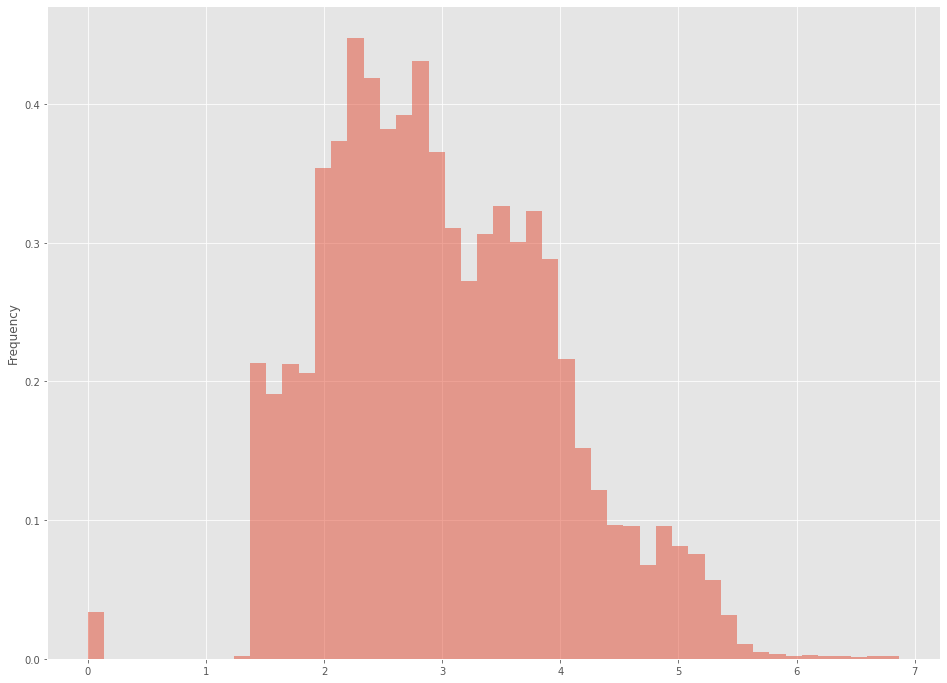

In [19]:
import scipy.stats as st
import statsmodels as sm
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

data.plot(kind='hist', bins=50, density=True, alpha=0.5)

<AxesSubplot:ylabel='Density'>

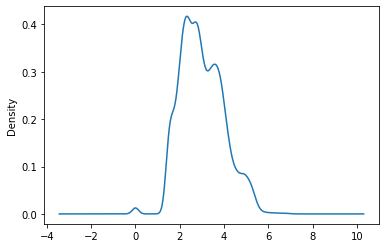

In [11]:
d_['demand_MW'].plot.density()

In [62]:
import numpy as np
import pandas as pd

#Test week
weather = pd.read_csv('a.csv', index_col =False, header=None)
submission = pd.read_csv('b.csv', index_col =False, header=None)
PV = pd.read_csv('c.csv', index_col =False, header=None)
demand = pd.read_csv('d.csv', index_col =False, header=None)

#Week 1
weather = pd.read_csv('week1/weather_train_set1.csv', index_col =False, header=None)
submission = pd.read_csv('week1/teamname_set1.csv', index_col =False, header=None)
PV = pd.read_csv('week1/pv_train_set1.csv', index_col =False, header=None)
demand = pd.read_csv('week1/demand_train_set1.csv', index_col =False, header=None)

In [63]:
# demand = pd.read_csv('week1/demand_train_set1.csv', index_col =False, header=None)

In [64]:
# PV = pd.read_csv('c.csv', index_col =False, header=None)

In [65]:
#Demand
d = demand
d.columns = d.iloc[0].astype(str)
d = d.drop(0)
d["datetime"] = pd.to_datetime(d["datetime"])
d = d.set_index('datetime')
d = d.astype('float64')
# d = d.replace(0, 0.001)

#Weather
w = weather
w.columns = weather.iloc[0].astype(str)
w = w.drop(0)
w["datetime"] = pd.to_datetime(w["datetime"])
w = w.set_index('datetime')
w = w.astype('float64')

#PV
pv = PV
pv.columns = pv.iloc[0].astype(str)
pv = pv.drop(0)
pv["datetime"] = pd.to_datetime(pv["datetime"])
pv = pv.set_index('datetime')
pv = pv.astype('float64')

In [66]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn import metrics

# y_train, y_test = train_test_split(y, shuffle=False)

#Score functions
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)


def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [67]:
#Include holiday data
import json
import requests
url = "https://www.gov.uk/bank-holidays.json"
json_request = requests.get(url)
python_dict = json_request.json()
dfs = []
for country, data in python_dict.items():
    df = pd.DataFrame(data['events'])
    df['Country'] = country
    dfs.append(df)

bank_hols = pd.concat(dfs, ignore_index=True)
val_bank_hols = bank_hols[bank_hols['Country'] == 'england-and-wales']['date']

In [68]:
#Feature Engineering
d_ = d[['demand_MW']]
d_.loc[:,'t-1'] = d_.loc[:,'demand_MW'].shift()
d_.loc[:,'t-1d'] = d_.loc[:,'t-1'].diff()
d_.loc[:,'t-2'] = d_.loc[:,'t-1'].shift()
d_.loc[:,'t-3'] = d_.loc[:,'t-2'].shift()
d_['week'] = d_.index.isocalendar().week
d_['month'] = d_.index.month
d_['year'] = d_.index.year
d_['weekday'] = d_.index.weekday
tod = pd.Series([(d_.index[i].hour*60 + d_.index[i].minute)/30 for i in range(len(d_.index))])
tod.index = d_.index
d_.loc[:,'tod'] = tod
d_.loc[:,'quarter']  = d_.index.quarter
d_['holiday'] = d_.index.isin(val_bank_hols)
d_['holiday'] = d_['holiday'].astype('float64')
d_ = d_.interpolate('ffill').dropna()

#Define Train and test sets
train_len = int(0.7*len(d_))
test_len = len(d_) - train_len

X_train = d_.iloc[0:train_len,:].drop(['demand_MW'],axis=1)
X_test = d_.iloc[test_len:,:].drop(['demand_MW'],axis=1)
y_train = d_.iloc[0:train_len]['demand_MW']
y_test = d_.iloc[test_len:]['demand_MW']


# X_train = d_[:'2017'].drop(['demand_MW'],axis=1)
# X_test = d_.loc['2018'].drop(['demand_MW'],axis=1)
# y_train = d_.loc['2017','demand_MW']
# y_test = d_.loc['2018','demand_MW']

#Preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.fit_transform(X_test)
#year transformation
#dayofyear, week
# min_max_scaler = preprocessing.MinMaxScaler()
# d_['year'] = pd.Series(pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(d_['year'])),columns=['year']))

In [71]:
#demand model

# model = RandomForestRegressor(n_estimators = 10, random_state=0)
# tscv = TimeSeriesSplit(n_splits=10)
# cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

X_train = d_.drop(['demand_MW'],axis=1)
y_train = d_['demand_MW']

model = RandomForestRegressor()#oob_score=True)
param_search = { 
    'n_estimators': [20, 50, 100],
#     'n_estimators': [20, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,14)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
# gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = metrics.mean_absolute_error)

gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

#Prediction
y_true = y_test.values
y_pred = best_model.predict(X_test)

#Score comparison
regression_results(y_true, y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not hav

explained_variance:  0.9972
mean_squared_log_error:  0.0002
r2:  0.9972
MAE:  0.0277
MSE:  0.0019
RMSE:  0.0438


In [73]:
best_score

-0.13397019457470677

In [72]:
1- best_model.oob_score_

0.011647527958876136

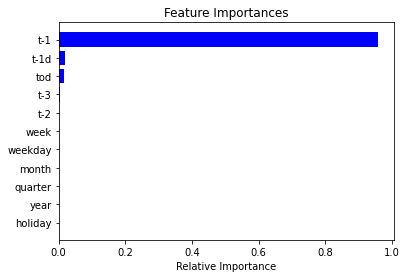

In [74]:
#Feature importance
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)

import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [75]:
#Demand Forecast
demand_prediction = d_.iloc[[-1],:].drop(['t-3'],axis=1)
cols = list(demand_prediction)
cols[1], cols[2] = cols[2], cols[1]
demand_prediction = demand_prediction[cols]
demand_prediction.columns = X_train.columns
old_demand_1 = demand_prediction['t-1'].iloc[-1]
old_demand_2 = demand_prediction['t-2'].iloc[-1]
# old_demand_3 = prediction['t-2'].iloc[-1]
for i in range(337):

    c = pd.to_datetime(demand_prediction.index + pd.Timedelta(hours=0.5))
    
    x = best_model.predict(pd.DataFrame(demand_prediction.iloc[-1]).T)
    new_df = pd.DataFrame([x[0],x[0]-old_demand_1,old_demand_1,old_demand_2,
                           c.isocalendar().week[i],c.month[i],c.year[i],c.weekday[i],
                           (c.hour[i]*60 + c.minute[i])/30,c.quarter[i],np.any(c[i] == val_bank_hols).astype('float64')]).T
    new_df.index = pd.DataFrame(c).iloc[i]
    new_df.columns = demand_prediction.columns
    demand_prediction = pd.concat([demand_prediction,new_df])
    old_demand_1 = demand_prediction['t-1'].iloc[-1]
    old_demand_2 = demand_prediction['t-2'].iloc[-1]
#     old_demand_3 = prediction['t-3'].iloc[-1]

demand_prediction

,t-1,t-1d,t-2,t-3,week,month,year,weekday,tod,quarter,holiday
2018-10-15 23:30:00,1.870000,0.020000,1.960000,1.940000,42,10.0,2018.0,0.0,47.0,4.0,0.0
2018-10-16 00:00:00,1.774800,-0.095200,1.870000,1.960000,42,10.0,2018.0,1.0,0.0,4.0,0.0
2018-10-16 00:30:00,1.838000,0.063200,1.774800,1.870000,42,10.0,2018.0,1.0,1.0,4.0,0.0
2018-10-16 01:00:00,1.752128,-0.085872,1.838000,1.774800,42,10.0,2018.0,1.0,2.0,4.0,0.0
2018-10-16 01:30:00,1.699521,-0.052608,1.752128,1.838000,42,10.0,2018.0,1.0,3.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-22 22:00:00,2.642700,-0.337300,2.980000,3.291400,43,10.0,2018.0,0.0,44.0,4.0,0.0
2018-10-22 22:30:00,2.333634,-0.309066,2.642700,2.980000,43,10.0,2018.0,0.0,45.0,4.0,0.0
2018-10-22 23:00:00,2.083818,-0.249816,2.333634,2.642700,43,10.0,2018.0,0.0,46.0,4.0,0.0
2018-10-22 23:30:00,1.966200,-0.117618,2.083818,2.333634,43,10.0,2018.0,0.0,47.0,4.0,0.0


In [77]:
demand_prediction = demand_prediction['2018-10-16':'2018-10-22']
demand_prediction['t-1'].to_excel("week1-demand.xlsx")  

In [61]:
# pd.concat([demand_prediction['t-1']['2018-07-23']*0.95,d['2018-07-23'],demand_prediction['t-1']['2018-07-23']*1.05],axis = 1)

In [51]:
# demand_prediction['t-1']['2018-07-23'] + 2*err

In [50]:
# d['2018-07-23']

In [49]:
err = 1- best_model.oob_score_  
# demand_prediction['t-1']['2018-07-23']- 2*err

In [77]:
# np.std(d_['demand_MW'])*2/np.sqrt(len(d_['demand_MW']))

In [42]:
regression_results(d['2018-07-23'], demand_prediction['t-1']['2018-07-23'])
# d['2018-07-23']

explained_variance:  0.9382
mean_squared_log_error:  0.0017
r2:  0.9352
MAE:  0.1159
MSE:  0.0198
RMSE:  0.1407


In [66]:
# demand_prediction['t-1']['2018-07-23'] + np.std(d_['demand_MW'])/np.sqrt(len(d_['demand_MW']))

In [65]:
# demand_prediction['t-1']['2018-07-23'] - np.std(d_['demand_MW'])/np.sqrt(len(d_['demand_MW']))

In [56]:
pv = PV
pv.columns = pv.iloc[0].astype(str)
pv = pv.drop(0)
pv["datetime"] = pd.to_datetime(pv["datetime"])
pv = pv.set_index('datetime')
pv = pv.astype('float64')

In [107]:
pv_forecast = w['2017-11-03':'2018-10-16 00:00']

In [362]:
w['2017-11-03':'2018-10-16 00:00']

,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
datetime,,,,,,,,,,,,
2017-11-03 00:00:00,7.46,13.20,9.64,6.68,13.09,8.56,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-03 01:00:00,7.14,13.32,9.71,6.27,13.21,8.69,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-03 02:00:00,6.86,13.36,9.73,5.91,13.30,8.74,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-03 03:00:00,6.60,13.47,9.81,5.60,13.38,8.84,0.0,0.0,0.0,0.0,0.0,0.0
2017-11-03 04:00:00,6.86,13.62,9.89,5.37,13.47,8.95,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-15 20:00:00,10.69,14.78,12.14,10.78,13.76,11.24,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-15 21:00:00,10.86,14.92,12.36,10.80,13.86,11.15,0.0,0.0,0.0,0.0,0.0,0.0
2018-10-15 22:00:00,10.95,14.95,12.49,11.11,13.98,11.33,0.0,0.0,0.0,0.0,0.0,0.0


In [376]:
# interpolate weather data and make sure dimension/timstep tallies with pv data
even_ = np.array(list(range(2*len(pv_forecast)))[0::2])
odd_ = np.array(list(range(2*len(pv_forecast)))[1::2])
temp_index = d['2017-11-03':'2018-10-16 00:00'].index

pv_forecast = w['2017-11-03':'2018-10-16 00:00']
pv_forecast.index = even_

# interpolate weather data for prediction

df_c = pd.DataFrame(pv_forecast.iloc[0]).T

for i in range(len(pv_forecast)-1):
    if(i == len(pv_forecast)):
        df = pd.DataFrame((pv_forecast.iloc[i])).T
    else:   
        df = pd.DataFrame((pv_forecast.iloc[i] + pv_forecast.iloc[i+1])/2).T
        df.columns = pv_forecast.columns
    df_c = pd.concat([df_c,df])

df_c.index = odd_ 
#Remove first row
df_c = df_c.drop(df_c.index[0])   
#reorder index
odd_ = np.array(list(range(2*len(df_c)))[1::2]) 
df_c.index = odd_  
# df_c = df_c.drop(df_c.index[-1]) 
w_forecast = pd.concat([pv_forecast,df_c]).sort_index()
w_forecast = w_forecast.drop(w_forecast.index[-1])
w_forecast.index = temp_index

In [383]:
#PV projection from weather data and historical PV
pv = pd.DataFrame(pv['pv_power_mw'])
# pv = pv[['pv_power_mw','panel_temp_C']]
# pv.loc[:,'t-1'] = pv.loc[:,'pv_power_mw'].shift()
# pv.loc[:,'t-1d'] = pv.loc[:,'t-1'].diff()
# pv.loc[:,'t-2'] = pv.loc[:,'t-1'].shift()
# pv.loc[:,'t-3'] = pv.loc[:,'t-2'].shift()
pv['month'] = pv.index.month
pv['year'] = pv.index.year
pv['weekday'] = pv.index.weekday
tod = pd.Series([(pv.index[i].hour*60 + pv.index[i].minute)/30 for i in range(len(pv.index))])
tod.index = pv.index
pv.loc[:,'tod'] = tod
pv.loc[:,'quarter']  = pv.index.quarter
pv['week'] = pv.index.isocalendar().week

#combine pv with weather data, then interpolate data
w_forecast['s_sum'] = (w_forecast['solar_location3'] + w_forecast['solar_location1'] + 
                     w_forecast['solar_location2']+ w_forecast['solar_location4'] + 
                     w_forecast['solar_location6'] + w_forecast['solar_location5'])

w_forecast['t_sum'] = (w_forecast['temp_location3'] + w_forecast['temp_location1'] + 
                     w_forecast['temp_location2']+ w_forecast['temp_location4'] + 
                     w_forecast['temp_location6'] + w_forecast['temp_location5'])

pv = pd.concat([pv,w_forecast['s_sum'],w_forecast['t_sum'],
                w_forecast[['temp_location3','temp_location6','temp_location2',
                            'temp_location4','temp_location5','temp_location1']],
                w_forecast[['solar_location3','solar_location6','solar_location2',
                            'solar_location4','solar_location5','solar_location1']]
               ],axis=1)


pv = pv.interpolate(method='ffill').dropna()
train_len = int(0.7*len(pv))
test_len = len(pv) - train_len


#Define Train and test sets
# X_train = pv.iloc[0:train_len,:].drop(['pv_power_mw'],axis=1)
# y_train = pv.iloc[0:train_len]['pv_power_mw']
X_train = pv.drop(['pv_power_mw'],axis=1)
y_train = pv['pv_power_mw']


X_test = pv.iloc[test_len:,:].drop(['pv_power_mw'],axis=1)
y_test = pv.iloc[test_len:]['pv_power_mw']

#Define model
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,14)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

#Prediction
y_true = y_test.values
y_pred = best_model.predict(X_test)

#Score comparison
regression_results(y_true, y_pred)

explained_variance:  0.8553
mean_squared_log_error:  0.0324
r2:  0.8552
MAE:  0.237
MSE:  0.1864
RMSE:  0.4317


In [180]:
#Correlation
# plt.scatter(w['2018-07-20']['temp_location3'],w['2018-07-20']['solar_location3'])
# plt.scatter(w_forecast['2018-07-20']['temp_location6'],pv['2018-07-20']['pv_power_mw'])

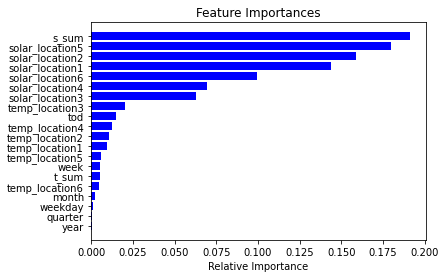

In [384]:
#Feature importance
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)

import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [491]:
#Interpolate weather data to match demand timestep
even_ = np.array(list(range(len(demand_prediction)))[0::2])
odd_ = np.array(list(range(len(demand_prediction)))[1::2])
temp_index = demand_prediction.index

pv_forecast_ = w['2018-10-16':]
pv_forecast_.index = even_


df_c_ = pd.DataFrame(pv_forecast_.iloc[0]).T

for i in range(len(pv_forecast_)-1):
    if(i == len(pv_forecast_)-1):
        df_ = pd.DataFrame((pv_forecast_.iloc[i])).T
    else:   
        df_ = pd.DataFrame((pv_forecast_.iloc[i] + pv_forecast_.iloc[i+1])/2).T
        df_.columns = pv_forecast_.columns
    df_c_ = pd.concat([df_c_,df_])

df_c_.index = odd_ 
#Remove first row
df_c_ = df_c_.drop(df_c_.index[0])   
#Project an extra half hour
df_c_ = pd.concat([df_c_,0.95*pd.DataFrame(pv_forecast_.iloc[-1]).T])
df_c_.index = odd_   
w_forecast_ = pd.concat([pv_forecast_,df_c_]).sort_index()
w_forecast_.index = temp_index

In [503]:
#Solar prediction
w_other = pd.DataFrame()
w_other['month'] = w_forecast_.index.month
w_other['year'] = w_forecast_.index.year
w_other['weekday'] = w_forecast_.index.weekday
tod = pd.Series([(w_forecast_.index[i].hour*60 + w_forecast_.index[i].minute)/30 for i in range(len(w_forecast_.index))])
w_other.loc[:,'tod'] = tod
w_other.loc[:,'quarter']  = w_forecast_.index.quarter
w_other['week'] = w_forecast_.index.week
#combine pv with weather data, then interpolate data
s_sum = (w_forecast_['solar_location3'] + w_forecast_['solar_location1'] + 
                          w_forecast_['solar_location2'] + w_forecast_['solar_location4'] + 
                          w_forecast_['solar_location6'] + w_forecast_['solar_location5'])
t_sum = (w_forecast_['temp_location3'] + w_forecast_['temp_location1'] + 
                          w_forecast_['temp_location2'] + w_forecast_['temp_location4'] + 
                          w_forecast_['temp_location6'] + w_forecast_['temp_location5'])
s_sum.index = tod.index
t_sum.index = tod.index
w_other.loc[:,'s_sum'] = s_sum
w_other.loc[:,'t_sum'] = t_sum



w_other.index = w_forecast_.index
w_other_ = pd.concat([w_other,w_forecast_],axis=1)

In [502]:
#Predict solar out and save to Excel sheet
result = pd.DataFrame(best_model.predict(w_other_))
result.index = w_forecast_.index
result.to_excel('week1-pv.xlsx')

In [113]:
### Testing model accuracy with new data

PV = pd.read_csv('week1/pv_train_set1.csv', index_col =False, header=None)
pv = PV
pv.columns = pv.iloc[0].astype(str)
pv = pv.drop(0)
pv["datetime"] = pd.to_datetime(pv["datetime"])
pv = pv.set_index('datetime')
pv = pv.astype('float64')

data = pd.DataFrame(x_)
data.index = solar_prediction.index[1:]

In [117]:
# regression_results(pv['2018-07-24']['pv_power_mw'], data['2018-07-24'])

In [76]:
# #Confidence interval
# stdev = np.sqrt(sum((best_model.predict(X_train) - y_train)**2) / (len(y_train) - 2))
# # (prediction - 1.96*stdev, prediction + 1.96*stdev)
stdev = np.sqrt(sum((best_model.predict(X_train) - y_train)**2) / (len(y_train) - 2))
x_low = pd.DataFrame(x_ - 1.96*stdev)
x_high = pd.DataFrame(x_ + 1.96*stdev)
x_mean = pd.DataFrame(x_)
pd.concat([x_low,x_mean,x_high],axis=1).iloc[15]

0    0.013774
0    0.868691
0    1.723608
Name: 15, dtype: float64

In [29]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
model = ConcreteModel()

days = 7
period = 48

#Charging profile
Bmin = -2.5
Bmax = 2.5
Cmax = 6

#Other important variables (energy demand, solar pv)
solar = pv['pv_power_mw']['2018-07-03']
e_demand = d['demand_MW']['2018-07-03']

#Define model, opt variables
model.IDX1 = range(days)
model.IDX2 = range(period)
model.B = Var(model.IDX1,model.IDX2,within=Reals)
model.C = Var(model.IDX1,model.IDX2,within = NonNegativeReals)
model.grid = Var(model.IDX1,model.IDX2,within = NonNegativeReals)

#Define constraints
model.c = ConstraintList()

#Begin everyday with zero charge
for i in model.IDX1:
    model.c.add(expr = model.C[i,0] == 0)
    
    #Battery charging progression
    for j in model.IDX2:
    # Constraints
    model.c.add(expr = model.grid[i,j] >= 0)
    model.c.add(expr = model.B[i,j] <= Bmax)
    model.c.add(expr = model.B[i,j] >= Bmin)
    model.c.add(expr = model.C[i,j] >= 0)
    model.c.add(expr = model.C[i,j] <= Cmax)   
    #When to charge
    if((i < 31)):
        model.c.add(expr = model.B[i,j] >= 0)
        model.c.add(expr = model.B[i,j] ==  model.grid[i,j] + np.float64(solar[i,j]))
    
    else:
        model.c.add(expr = model.B[i,j] <= 0)
        model.c.add(expr = model.grid[i,j] ==  0)
        if (i >= (period-1)):
            continue
        model.c.add(expr = model.C[i,j+1] == model.C[i,j] + np.float64(0.5)*model.B[i,j])


model.cost = Objective(
        expr = sum([e_demand[i][31:42] for i in model.IDX1]) + sum([(model.B[i,j] for i in range(31,42)) for i in model.IDX1]) + (sum([[model.grid[i,j] for j in range(31)] for i in model.IDX1])) 
)


# solve
SolverFactory('gurobi_direct').solve(model)#.write()
# SolverFactory('ipopt').solve(model)#.write()
# SolverFactory('mosek').solve(model)

#Print results
print('Cost = ',model.cost())

In [ ]:
##Optimization problem
# import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
model = ConcreteModel()

days = 7
period = 48

#Charging profile
Bmin = -2.5
Bmax = 2.5
Cmax = 6

#Other important variables
solar = pv['pv_power_mw']['2018-07-03']
e_demand = d['demand_MW']['2018-07-03']

#Define model, opt variables
model.IDX1 = range(days)
model.IDX2 = range(period)
# model.IDX2 = RangeSet(0, 4)
model.B = Var(model.IDX2,within=Reals)
model.C = Var(model.IDX2,within = NonNegativeReals)
model.grid = Var(model.IDX2,within = NonNegativeReals)

#Define constraints
model.c = ConstraintList()

#Begin day with zero charge
model.c.add(expr = model.C[0] == 0)

#Battery charging progression
for i in range(period):
    if(i >= (period-1)):
        continue
    model.c.add(expr = model.C[i+1] == model.C[i] + np.float64(0.5)*model.B[i])
    

for i in model.IDX2:
    # Constraints
    model.c.add(expr = model.grid[i] >= 0)
    model.c.add(expr = model.B[i] <= Bmax)
    model.c.add(expr = model.B[i] >= Bmin)
    model.c.add(expr = model.C[i] >= 0)
    model.c.add(expr = model.C[i] <= Cmax)
    
    
    #When to charge
    if((i < 31)):
        model.c.add(expr = model.B[i] >= 0)
        model.c.add(expr = model.B[i] ==  model.grid[i] + np.float64(solar[i]))
    
    else:
        model.c.add(expr = model.B[i] <= 0)
        model.c.add(expr = model.grid[i] ==  0)

terms = 8
model.cost = Objective(
        expr = sum(e_demand[31:42]) + sum((model.B[i] for i in range(31,42))) + sum([model.grid[i] for i in range(31)])
)


# model.cost_ = Objective(
#         expr = sum(solar[:31])/sum([model.B[i] for i in range(31)])
# )

# model.cost = Objective(
#         expr =  sum( [(-1)**n*(sum([model.B[i] for i in range(31)]) - 1)**n for n in range(terms)])
# )
# model.cost = Objective(
#         expr = log(sum([model.B[i] for i in range(31)])), sense = maximize
# )

# solve
# SolverFactory('gurobi_direct').solve(model)#.write()
SolverFactory('ipopt').solve(model)#.write()
# SolverFactory('mosek').solve(model)

#Print results
print('Cost = ',model.cost())

In [43]:
sum(solar[:31])/sum((model.B[i].value for i in range(31)))

1.0686498900267654

In [45]:
# np.array(solar[:31])
# np.array([model.B[i].value for i in range(31)])
# np.array([model.C[i].value for i in range(48)])
# e_demand[31:42]
# [model.grid[i].value for i in model.IDX2]
sum_ = 0
for i in range(31):
    if(model.B[i].value >= solar[i]):
        sum_ = sum_ + model.B[i].value-solar[i]
sum_/sum([model.B[i].value for i in range(31)])

2.46126258346752e-10